In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib notebook

from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score, f1_score, confusion_matrix

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack
import datetime

import utils
import importlib
importlib.reload(utils)

double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

/home/max/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('docs.csv').sample(frac=1).reset_index(drop=True)
df['date'] = df['rated'].apply(lambda x: datetime.datetime.strptime(x[:19],"%Y-%m-%d %H:%M:%S"))
df = df[df['date'] > datetime.datetime(2018,6,1,0,0,0)].reset_index(drop=True)
print(df.shape)
y = df['relevant']
df.head()

(1984, 13)


,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date
0,1499,WOS:A1996UD68200005,"Asheim, GB","It is shown within a given framework that, wit...","Asheim, GB",322394,2018-09-21 10:55:48.014573+00:00,1,753,Capital gains and net national product in open...,net national product; open economies; capital ...,['Economics'],2018-09-21 10:55:48
1,2007,WOS:000367769800011,"Bartzas, G, Komnitsas, K",Ferronickel (FeNi) is predominantly produced f...,"Bartzas, G",253651,2018-09-24 03:29:20.691385+00:00,1,760,Life cycle assessment of ferronickel productio...,Ferronickel; LCA; Nickel laterite ore; Pyromet...,"['Engineering, Environmental; Environmental Sc...",2018-09-24 03:29:20
2,1013,WOS:000390459900001,"Ma, Y, Zhao, YJ, Diao, JT, Gan, LX, Bi, HX, Zh...",To achieve the wind sail-assisted function of ...,"Ma, Y",408176,2018-09-24 03:54:47.362165+00:00,1,760,Design of Sail-Assisted Unmanned Surface Vehic...,NaN,"['Engineering, Multidisciplinary; Mathematics,...",2018-09-24 03:54:47
3,249,WOS:000340539000006,"Serna-Mansoux, L, Popoff, A, Millet, D","For many modern products, the use phase is int...","Serna-Mansoux, L",196265,2018-09-21 12:36:20.324554+00:00,1,760,A Simplified Model to Include Dynamic Product-...,eco-design; environmental impact in product us...,['GREEN & SUSTAINABLE SCIENCE & TECHNOLOGY; En...,2018-09-21 12:36:20
4,2270,WOS:A1991GL80200003,"ORIORDAN, T",Environmentalism is a metaphor for both how we...,"ORIORDAN, T",244900,2018-09-06 10:04:43.432286+00:00,1,732,THE NEW ENVIRONMENTALISM AND SUSTAINABLE DEVEL...,NaN,['Environmental Sciences'],2018-09-06 10:04:43


In [3]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=15, max_df=0.6, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X = vec.fit_transform(df['content'])
ab_X.shape

vec = TfidfVectorizer(
    ngram_range=(1,3),
    min_df=5, max_df=0.8, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X_dense = vec.fit_transform(df['content'])
ab_X_dense.shape

vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=10, max_df=0.9, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)


ti_X = vec.fit_transform(df['title'])
ti_X.shape

# keywords
import re
def kw_tokenize(X):
    for x in X.split(';'):
        t = x.replace('[','').replace(']','').strip()
        t = t.replace("'","")
        t = re.sub('^, ','',t)
        t = t.replace(',,',',')
        if len(x) < 2:
            continue
        yield t

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=kw_tokenize
)
df['wosarticle__wc'] = df['wosarticle__wc'].fillna("")
wc_X = vec.fit_transform(df['wosarticle__wc'])
print(wc_X.shape)
vec.get_feature_names()[:5]

# keywords

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=kw_tokenize
    #tokenizer=lambda x: x.split('; ')
)
df['wosarticle__de'] = df['wosarticle__de'].fillna("")
de_X = vec.fit_transform(df['wosarticle__de'])
print(de_X.shape)
vec.get_feature_names()[:5]

vec = CountVectorizer(
    ngram_range=(1,1),
    min_df=1, max_df=0.9, strip_accents='unicode', 
    stop_words="english",tokenizer=utils.tokenize
)
df['authors'] = df['authors'].fillna("")
au_X = vec.fit_transform(df['authors'])
print(au_X.shape)
vec.get_feature_names()[:5]

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=utils.sus_tokenize
    #tokenizer=lambda x: x.split('; ')
)
sus_X = vec.fit_transform(df['content'])

X = hstack([ab_X,sus_X],format="csr")

nmf = NMF(n_components=125,random_state=1,
          alpha=.1, l1_ratio=.5)

W = nmf.fit_transform(X)


(1984, 162)
(1984, 323)
(1984, 5561)


In [4]:
train = df.sample(frac=0.5).copy()
test = df[~df['id'].isin(train['id'])].copy()

In [5]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(X, y, random_state=1)
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

[WARNING] [2018-09-26 21:24:49,262:EnsembleBuilder(1):4f389199fd49cea4bfaa07e0e686b1ba] No models better than random - using Dummy Classifier!
[WARNING] [2018-09-26 21:24:49,269:EnsembleBuilder(1):4f389199fd49cea4bfaa07e0e686b1ba] No models better than random - using Dummy Classifier!
[WARNING] [2018-09-26 21:24:50,284:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-09-26 21:24:50,284:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/ma

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `a

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:228: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

/home/max/.local/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices]) > 0:
/home/max/.local/lib/python3.6/site-packages/autosklearn/pipeline/create_searchspace_util.py:208: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(matches[slices_]) == 0:
/home/m

Accuracy score 0.8608870967741935


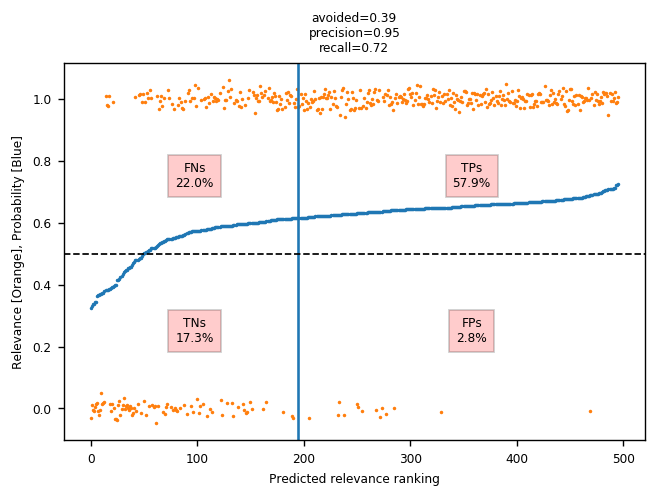

In [6]:
fig, ax = plt.subplots(dpi=125)
utils.plot_model_accuracy(automl,X_test,y_test,ax, 0.615)

Confusion matrix, without normalization
[[ 40  60]
 [  9 387]]


0.8608870967741935

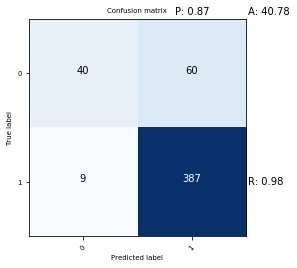

In [7]:
cnf = confusion_matrix(y_test,automl.predict(X_test))
utils.plot_confusion_matrix(cnf,classes=[0,1])
automl.score(X_test,y_test)

In [8]:
import warnings; warnings.simplefilter('ignore')

Average precision-recall score: 0.96


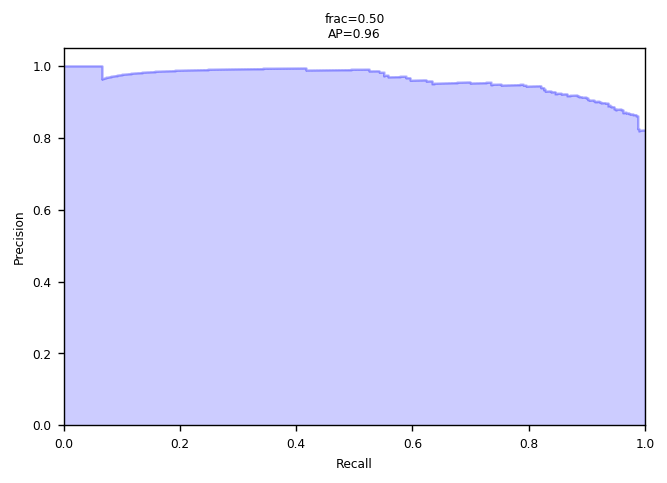

In [9]:
fig, ax = plt.subplots(dpi=125)
utils.precision_recall_plot(automl,X_test,y_test,ax,0.5)

In [10]:

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
    {
        'title': 'abs, kw, sus',
        'X': hstack([ab_X,de_X,sus_X],format="csr")
    },
    {
        'title': 'abs_d, kw, sus',
        'X': hstack([ab_X_dense,de_X,sus_X],format="csr")
    },
    {
        'title': 'abs_d, kw, sus\nwc, ti',
        'X': hstack([ab_X,de_X,sus_X,wc_X,ti_X],format="csr")
    }
]

In [11]:
for x in xs:
    x['X_train'], x['X_test'], x['y_train'], x['y_test'] = \
        sklearn.model_selection.train_test_split(X, y, random_state=1)
    x['automl'] = autosklearn.classification.AutoSklearnClassifier()
    automl.fit(x['X_train'], x['y_train'])
    x['y_hat'] = automl.predict(x['X_test'])
    print(x['title'])
    print("Accuracy score", sklearn.metrics.accuracy_score(x['y_test'], x['y_hat']))

[WARNING] [2018-09-26 22:24:47,864:EnsembleBuilder(1):4f389199fd49cea4bfaa07e0e686b1ba] No models better than random - using Dummy Classifier!
[WARNING] [2018-09-26 22:24:47,870:EnsembleBuilder(1):4f389199fd49cea4bfaa07e0e686b1ba] No models better than random - using Dummy Classifier!
[WARNING] [2018-09-26 22:24:48,941:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-09-26 22:24:48,941:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-09-26 22:31:36,139:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-09-26 22:31:36,139:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-09-26 22:50:26,734:smac.intensification.intensification.Intensifier] Challenge

Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/max/.local/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 119, in subprocess_func
    for child in p.children(recursive=True):
  File "/home/max/.local/lib/python3.6/site-packages/psutil/__init__.py", line 285, in wrapper
    return fun(self, *args, **kwargs)
  File "/home/max/.local/lib/python3.6/site-packages/psutil/__init__.py", line 892, in children
    ppid_map = _ppid_map()
  File "/home/max/.local/lib/python3.6/site-packages/psutil/_pslinux.py", line 1437, in ppid_map
    with open_binary("%s/%s/stat" % (procfs_path, pid)) as f:
  File "/home/max/.local/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 31, in handler
    raise(TimeoutException)
pynisher.

titles, abs,
kw, wc
Accuracy score 0.8669354838709677
[WARNING] [2018-09-27 01:24:36,217:EnsembleBuilder(1):4f389199fd49cea4bfaa07e0e686b1ba] No models better than random - using Dummy Classifier!
[WARNING] [2018-09-27 01:24:36,222:EnsembleBuilder(1):4f389199fd49cea4bfaa07e0e686b1ba] No models better than random - using Dummy Classifier!
[WARNING] [2018-09-27 01:24:37,247:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-09-27 01:24:37,247:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-09-27 01:47:02,985:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-09-27 01:47:02,985:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
titles, abs
Accuracy score 0.86290322580